In [156]:
%%capture

# инструменты анализа и обработки данных
import pandas as pd
import numpy as np
import re
from scipy import stats
from category_encoders import  OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif

# инструменты для лингвистического анализа:
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('popular')

# инструменты для визуализации:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


# инструменты для построения модели:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# фиксируем RANDOM_SEED и версию пакетов, чтобы эксперименты были воспроизводимы:
RANDOM_SEED = 42
#!pip freeze > requirements.tx

In [157]:
train_df = pd.read_csv(r'C:\Users\Lenovo\Dropbox\SKILLFACTORY\IDE\Py_EDA_8_ProjectML_3_Kaggle\data\hotels_train.csv')
train_df.shape

(386803, 17)

In [158]:
test_df = pd.read_csv(r'C:\Users\Lenovo\Dropbox\SKILLFACTORY\IDE\Py_EDA_8_ProjectML_3_Kaggle\data\hotels_test.csv')
test_df.shape

(128935, 16)

### Объединяем train_df & test_df для этого:
- Создаем сигнальный признак для маркироки датасетов 
- Добавляем reviewer_score в test_df
- Объединяем датасеты

In [159]:

# cоздаем сигнальный признак для маркироки датасетов 
train_df['sample'] = 1 # помечаем трейн
test_df['sample'] = 0 # помечаем тест

# в тесте у нас нет значения reviewer_score, заполняем нулями:
test_df['reviewer_score'] = 0 

# объединяем датасеты
hotels = test_df.append(train_df, sort=False).reset_index(drop=True)
display(hotels.shape)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2644\41594934.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hotels = test_df.append(train_df, sort=False).reset_index(drop=True)


(515738, 18)

## Выводим общую информацию по таблице:

In [160]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

=> Видим, что пропуски в данных встречаются лищь для признаков долготы и широты => займемся этим позже

## Выводим общую информацию по уникальным и наиболее распр. признакам:

### создается функция для создания таблицы по датафрейму содержащей:
- наимен признака, 
- кол-ва уник значений, 
- названия наиболее распространенных значений, 
- % наиб распр. значений,
- абс. кол-ва для наиб распр значения

In [161]:
def get_top_unique_values(df, level=0):
    """
    Функция для получения инфомации по уникальным значениям в признаках
    параметры:
    df - Датафрейм для анализа
    level - Уровень уникальности в %, признаки ниже этого уровня не выводятся
    return - Возвращает датафрейм с именем признака, количестве уникальных значений, наиболее часто повторяющимся
    уникальным значением, сколько % от выборки это значение занимает, количество повторов
    """

    cols = df.columns.tolist()

    # создаём пустой список
    unique_list = []

    for col in cols:
        col_lev = round(df[col].value_counts(normalize=True).values[0] * 100, 2)
        # col_lev returns top % for the most frequent value

        if col_lev > level:
            item = (col, df[col].nunique(), df[col].value_counts(normalize=True).index[0], col_lev,
                    df[col].value_counts().values[0])
            # собираем кортеж из:
            # наимен признака, 
            # кол-ва уник значений, 
            # названием наиб распр значения, 
            # % наиб распр. значения,
            # общего кол-ва для наиб распр значения
            # добавляем кортеж в список
            unique_list.append(item)

    unique_values = pd.DataFrame(
        unique_list,
        columns=['Column Name', 'Count Unique', 'Top Value', 'Top Value %', 'Top Value Count']
    )

    return unique_values

In [162]:
top_info_df = get_top_unique_values(hotels)
display(top_info_df)

,Column Name,Count Unique,Top Value,Top Value %,Top Value Count
0,hotel_address,1493,163 Marsh Wall Docklands Tower Hamlets London ...,0.93,4789
1,additional_number_of_scoring,480,2682,0.93,4789
2,review_date,731,8/2/2017,0.50,2585
3,average_score,34,8.4,7.99,41222
4,hotel_name,1492,Britannia International Hotel Canary Wharf,0.93,4789
5,reviewer_nationality,227,United Kingdom,47.55,245246
6,negative_review,330011,No Negative,24.80,127890
7,review_total_negative_word_counts,402,0,24.80,127890
8,total_number_of_reviews,1142,9086,0.93,4789
9,positive_review,412601,No Positive,6.97,35946


=> видим, что уникальных адресов на один больше чем уникальных названий отеля => это вполне ожидаемо и даже удивительно, что имена отелей дублируются так редко => проанализируем признак 'hotel_name'

## 1. Анализируем признак 'hotel_name'
### Найдем отели с повторяющимся названием и промаркируем их

In [163]:
# найдем отель с повторяющимся имененм:
name_vs_address = hotels[['hotel_name','hotel_address']].groupby(by='hotel_name').nunique()
# сохраним индекс(ы) отелей с повторными именами:
nonunique_hotel_name = name_vs_address[name_vs_address['hotel_address'] > 1].index.tolist()
display(nonunique_hotel_name)
# посмотрим какие адреса соответствуют отелю 'Hotel Regina'
HotelRegina_ads = hotels[hotels['hotel_name'] == 'Hotel Regina']['hotel_address'].value_counts().index.tolist()

# добавим название города к названию повторяющегося отеля

# извлечем все индексы соотв этому отелю:
HotelRegina_index = hotels[hotels['hotel_name'].isin(nonunique_hotel_name)].index.tolist()

# сохраним индексы целиковой таблице в виде серии для того, чтобы применить к ним функцию 'apply':
index_series = pd.Series(hotels.index)

# добавим город к названию соотв. отеля по индексу
hotels['hotel_name'] = index_series.apply(lambda ind: (hotels['hotel_name'][ind] + 
                                        ' ' + '(' + hotels['hotel_address'][ind].split()[-2] +')')
                                        if (ind in HotelRegina_index)
                                        else hotels['hotel_name'][ind])
                       
# Выведем соотв. строки чтобы удостовериться во внесенных изменениях:
mask = hotels['hotel_name'].str.contains(nonunique_hotel_name[0])
display(hotels[mask]['hotel_name'].value_counts())


['Hotel Regina']

Hotel Regina (Barcelona)    590
Hotel Regina (Vienna)       284
Hotel Regina (Milan)         60
Name: hotel_name, dtype: int64

In [164]:
hotels.groupby('hotel_name')['average_score'].last().sort_values(ascending=False)

hotel_name
Ritz Paris                                  9.8
H10 Casa Mimosa 4 Sup                       9.6
H tel de La Tamise Esprit de France         9.6
41                                          9.6
Hotel The Serras                            9.6
                                           ... 
Best Western Maitrise Hotel Edgware Road    6.6
The Tophams Hotel                           6.6
Hotel Cavendish                             6.4
Savoy Hotel Amsterdam                       6.4
Hotel Liberty                               5.2
Name: average_score, Length: 1494, dtype: float64

удалим строковый признак 'hotel_name' - т.к. его дублирует признак рейтинга отеля: 'avergae_score'

In [165]:
hotels.drop('hotel_name', axis=1, inplace=True)

## 2. Анализ признака 'hotel_address'
### Составим список стран и городов для последующего проектирования соответствующих бинарных признаков

In [166]:
hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: 
    (' '.join(x.split()[-2:])) if x.split()[-1] == 'Kingdom' else x.split()[-1])
hotels['hotel_city'] = hotels['hotel_address'].apply(lambda x:
    x.split()[-5] if (x.split()[-1] == 'Kingdom') else x.split()[-2])


In [167]:
# Посмотрим на кол-во городов в разрезе стран:
country_city = hotels.groupby(['hotel_country', 'hotel_city'])['hotel_address'].count()
country_city.head(8)

hotel_country   hotel_city
Austria         Vienna         38939
France          Paris          59928
Italy           Milan          37207
Netherlands     Amsterdam      57214
Spain           Barcelona      60149
United Kingdom  London        262301
Name: hotel_address, dtype: int64

видим, что на каждую страну приходится один крупный город - т.о. можно закодирвать либо страны либо города: закодируем страны

In [168]:
# Кодирование стран через атрибут метода cat (Идея взята из ноутбука победителя конкурса MargoritaK)
hotels['hotel_country'] = hotels['hotel_country'].astype('category')
hotels['hotel_country_code'] = hotels['hotel_country'].cat.codes
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,hotel_country,hotel_city,hotel_country_code
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,Italy,Milan,2
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,Netherlands,Amsterdam,3
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0,Spain,Barcelona,4


In [169]:
# Удалим соотв. столбцы: hotel_address, hotel_country, hotel_city
hotels.drop(['hotel_address','hotel_country','hotel_city'], axis=1, inplace=True)

## 3. Анализируем признак национальность посетителя 'reviewer_nationality'


In [170]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   review_date                                 515738 non-null  object 
 2   average_score                               515738 non-null  float64
 3   reviewer_nationality                        515738 non-null  object 
 4   negative_review                             515738 non-null  object 
 5   review_total_negative_word_counts           515738 non-null  int64  
 6   total_number_of_reviews                     515738 non-null  int64  
 7   positive_review                             515738 non-null  object 
 8   review_total_positive_word_counts           515738 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 

In [171]:
countries = hotels['reviewer_nationality'].value_counts()
display(countries)

# Установим порог в 100 человек и соотв. найдем страны из которых было не менее 100 посетителей:
# суммарная доля посетителей из стран откуда прибыло > 100 посетителей
display(round(countries[countries > 100].sum()/countries.sum()*100,1))
# суммарная доля посетителей из стран откуда прибыло <= 100 посетителей
display(round(countries[countries <= 100].sum()/countries.sum()*100,1))

# видим, что доля посетитлей при установке барьера в 100 человек соотв 95.5% посетителей которые будут перекодированы на основе культурно-религиозно-языковых особенностей
# сохраняем такие страны в список и выводим их количество
lst = countries[countries > 100].index.tolist()
print(len(lst)) # 101
# выводим все страны порциями по 10 для распределения по культурно-религиозно-языковым группам
for i in range(11):
    print(lst[0:10])
    lst = lst[10:]
# на основе результата разбираем страны по группам - см. ниже


 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
                               ...  
 Comoros                           1
 Anguilla                          1
 Tuvalu                            1
 Cape Verde                        1
 Palau                             1
Name: reviewer_nationality, Length: 227, dtype: int64

99.5

0.5

101
[' United Kingdom ', ' United States of America ', ' Australia ', ' Ireland ', ' United Arab Emirates ', ' Saudi Arabia ', ' Netherlands ', ' Switzerland ', ' Germany ', ' Canada ']
[' France ', ' Israel ', ' Italy ', ' Belgium ', ' Turkey ', ' Kuwait ', ' Spain ', ' Romania ', ' Russia ', ' South Africa ']
[' India ', ' Greece ', ' China ', ' Sweden ', ' New Zealand ', ' Singapore ', ' Hong Kong ', ' Poland ', ' Qatar ', ' Austria ']
[' Egypt ', ' Norway ', ' Czech Republic ', ' Lebanon ', ' Hungary ', ' Malaysia ', ' Thailand ', ' Brazil ', ' Portugal ', ' Finland ']
[' Denmark ', ' Malta ', ' Bahrain ', ' Indonesia ', ' Cyprus ', ' Luxembourg ', ' Croatia ', ' Oman ', ' Bulgaria ', ' Japan ']
[' Serbia ', ' Ukraine ', ' Iran ', ' South Korea ', ' Philippines ', ' Nigeria ', ' Iceland ', ' Taiwan ', ' Pakistan ', ' Slovakia ']
[' Jersey ', ' Slovenia ', ' Estonia ', ' Jordan ', ' Lithuania ', ' Latvia ', ' Mexico ', ' Guernsey ', ' ', ' Argentina ']
[' Isle of Man ', ' Gibraltar 

видим что в 7-ом списке встречается пробел вместо названия страны: посмотрим сколько таких вариантов

In [172]:
mask = hotels['reviewer_nationality'] == ' '
display(hotels[mask].shape[0])
hotels[mask]['sample'].value_counts()

523

1    395
0    128
Name: sample, dtype: int64

строки с пропусками составляют 0.1% - добавим их к western_nations на основе наибольшей представленности последних

Национальность значение строковое, всего национальностей больше 200, разделим национальности по основным типам культурно-религиозно-языкового менталитета:
- western_nations - сюда мы отнесем европу америку и сопутствующие страны + пропуски
- islamic_nations - исламские страны
- eastern_nations - сюда относим старны бывшего СССР и страны долгое время находившиеся в орбите СССР (восточный блок и т.д.)
- israeli_nation - (выделяем в отдельную группу так как иудаизм как гос. религия исповедуется только в этой стране и предполагает особый кодекс поведения)
- latin_america_africa - не очень распространены и потому объединяем два континента в одну группу
- asian_nations - 
- english_speaking - список довольно условный, члены которого дублируют представителей других списков выше
- other_nations - оставшиеся

In [173]:
# Списки стран объединенных историей/культурой/религией или собранные по остаточному принципу
western_nations = [' United Kingdom ',' United States of America ',' Australia ',
                   ' Ireland ',' Netherlands ',' Switzerland ',' Germany ',
                   ' Canada ',' France ',' Italy ', ' Belgium ',' Spain ', ' Romania ',
                   ' Greece ',' Sweden ', ' New Zealand ',' Poland ',' Austria ',
                   ' Norway ', ' Czech Republic ',' Hungary ',' Portugal ', ' Finland ',
                   ' Denmark ', ' Malta ',' Cyprus ',' Luxembourg ',' Croatia ',' Iceland ',
                   ' Slovakia ',' Slovakia ',' Estonia ',' Lithuania ',' Latvia ',' Guernsey ',
                   ' Isle of Man ',' Gibraltar ',' Monaco ', ' ']
latin_america_africa = [' South Africa ',' Brazil ',' Nigeria ',' Mexico ',' Argentina ',
                        ' Chile ',' Colombia ',' Kenya ',' Puerto Rico ',' Trinidad and Tobago ',
                        ' Ghana ',' Panama ',' Costa Rica ',' Peru ',' Bermuda ']
islamic_nations = [' United Arab Emirates ',' Saudi Arabia ',' Turkey ',' Kuwait ',
                   ' Qatar ',' Egypt ',' Lebanon ',' Bahrain ',' Oman ',' Iran ',' Pakistan ',
                   ' Jordan ',' Iraq ',' Azerbaijan ',' Morocco ',' Mauritius ',' Bangladesh ']
eastern_nations = [' Russia ',' Bulgaria ',' Serbia ',' Ukraine ',' Slovenia ',' Georgia ',
                  ' Albania ',' Macedonia ',' Kazakhstan ',' Bosnia and Herzegovina ',
                  ' Belarus ',' Montenegro ',' Abkhazia Georgia ',' Armenia ',' Moldova ']
israel_nation = [' Israel ']
asian_nations = [' India ',' China ',' Singapore ',' Hong Kong ',' Malaysia ',
                 ' Thailand ',' Indonesia ',' Japan ',' South Korea ',' Philippines ',
                 ' Taiwan ',' Sri Lanka ',' Vietnam ',' Macau ']
english_speaking = [' United Kingdom ',' United States of America ',' Australia ',
                   ' Ireland ',' Netherlands ',' Switzerland ',' Germany ',
                   ' Canada ',' Belgium ',' Sweden ', ' New Zealand ',' Poland ',' Austria ',
                   ' Norway ', ' Portugal ', ' Finland ',' Denmark ', ' Malta ',' Cyprus ',
                   ' Luxembourg ',' Iceland ',' Guernsey ',' Isle of Man ',' Gibraltar ',' Monaco ',' South Africa ',
                   ' Kenya ',' Bangladesh ',' Israel ',' India ',' Hong Kong ',' Taiwan ',' Sri Lanka ']
# страны(национальности) кол-ва посетителей из которых не преодолели порог сохраним в список 'other_nations'
other_nations = countries[countries <= 100].index.tolist()

    

- 1. Создадим список названий групп из которого будем извлекать названия для столбцов, соотв.
- 2. Создадим гиперсписок по которому будем итерироваться в цикле


In [174]:
# 1.
list_names=['western_nation', 'islamic_nation', 'eastern_nation', 'israel_nation', 'asian_nation','latin_america_africa', 'english_speaking', 'other_nation']

# 2.
list_of_lists = []
list_of_lists.append(western_nations)
list_of_lists.append(islamic_nations)
list_of_lists.append(eastern_nations)
list_of_lists.append(israel_nation)
list_of_lists.append(asian_nations)
list_of_lists.append(latin_america_africa)
list_of_lists.append(english_speaking)
list_of_lists.append(other_nations)

In [175]:
# создаем функцию для сверки и перекодировки значений столбца
def country_recode(name, lst):
    if name in lst:
        return 1
    return 0

# Применяем функцию в цикле создавая новые столбцы признаки:
i = 0
for list in list_of_lists:
    hotels[list_names[i]] = hotels['reviewer_nationality'].apply(country_recode, args=(list,))
    i += 1

hotels.head(3)

,additional_number_of_scoring,review_date,average_score,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,reviewer_score,hotel_country_code,western_nation,islamic_nation,eastern_nation,israel_nation,asian_nation,latin_america_africa,english_speaking,other_nation
0,904,7/21/2017,8.1,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,...,0.0,2,1,0,0,0,0,0,1,0
1,612,12/12/2016,8.6,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,...,0.0,3,1,0,0,0,0,0,1,0
2,46,11/26/2015,8.3,Sweden,Pillows,3,351,Nice welcoming and service,5,15,...,0.0,4,1,0,0,0,0,0,1,0


посмотрим насколько средняя оценка меняется в разрезе новых признаков
(идея построения подобной визуализации взята из ноутбука победителя конкурса прекрасной MargaritaK)

,western_nation,islamic_nation,eastern_nation,asian_nation,israel_nation,latin_america_africa,english_speaking,other_nations
0,8.140735,8.440289,8.399498,8.406104,8.393001,8.396927,8.127482,8.397842
1,8.456242,7.929407,8.271563,8.201312,8.700142,8.395829,8.473481,8.209870


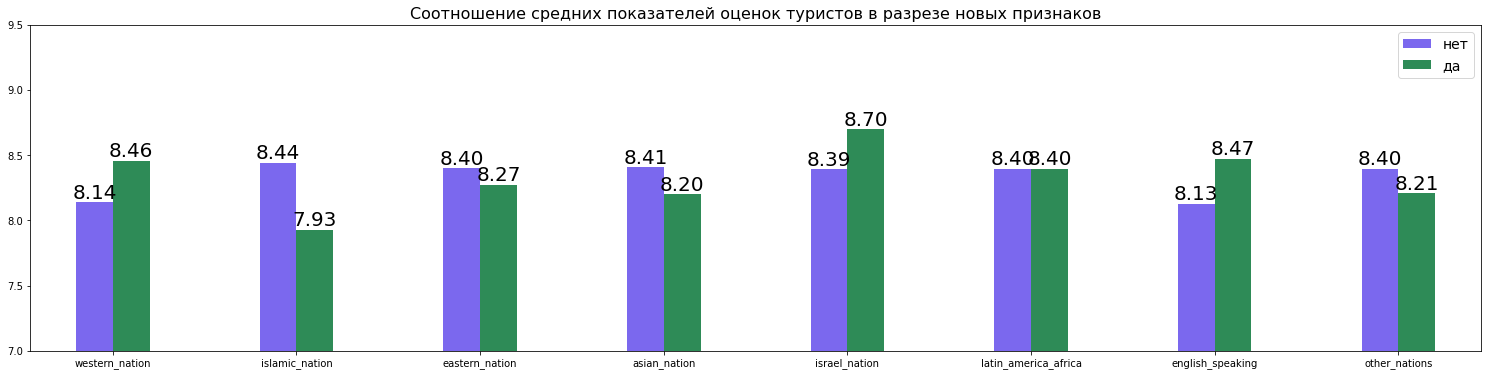

In [176]:
# подготовим данные для диаграммы:
mask = hotels['sample'] == 1
pivot_western_nation = hotels[mask].groupby('western_nation')['reviewer_score'].mean()
pivot_islamic_nation = hotels[mask].groupby('islamic_nation')['reviewer_score'].mean()
pivot_eastern_nation = hotels[mask].groupby('eastern_nation')['reviewer_score'].mean()
pivot_asian_nation = hotels[mask].groupby('asian_nation')['reviewer_score'].mean()
pivot_israel_nation = hotels[mask].groupby('israel_nation')['reviewer_score'].mean()
pivot_latin_america_africa = hotels[mask].groupby('latin_america_africa')['reviewer_score'].mean()
pivot_english_speaking = hotels[mask].groupby('english_speaking')['reviewer_score'].mean()
pivot_other_nation = hotels[mask].groupby('other_nation')['reviewer_score'].mean()


pivot = pd.DataFrame({
    'western_nation': pivot_western_nation,
    'islamic_nation': pivot_islamic_nation,
    'eastern_nation': pivot_eastern_nation, 
    'asian_nation': pivot_asian_nation,
    'israel_nation': pivot_israel_nation,
    'latin_america_africa': pivot_latin_america_africa,
    'english_speaking': pivot_english_speaking,
    'other_nations': pivot_other_nation
})
display(pivot)

labels = pivot.columns.tolist()

# строим диаграмму:
fig2, ax2 = plt.subplots(figsize=(26, 6))
pivot_barplot = pivot.transpose().plot( # transpose dataframe is required to group bars according to rows (two rows => bar-pairs)
                                       # not according to columns when 7-bars would be arranged in two groups 
    ax=ax2, 
    kind='bar', 
    width=0.4,
    color=['mediumslateblue', 'seagreen'],
    rot=0,
    xlabel=labels,
    )
ax2.set_title(
    'Соотношение средних показателей оценок туристов в разрезе новых признаков', size=16)
ax2.set_xlabel('')
#ax2.set_xticklabels(groups, fontsize=16)
ax2.legend(['нет', 'да'], loc='upper right', fontsize=14)


# для наглядности добавим на диаграмму подписи данных:
for p in pivot_barplot.patches:
    pivot_barplot.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()),
    ha='center', va='bottom', fontsize=20)

plt.ylim(7, 9.5);

Удалим исходный строчный признак - "reviewer_nationality" и признак 'latin_america_africa' 

In [177]:
hotels.drop(['reviewer_nationality','latin_america_africa'], axis=1, inplace=True)

## 4. Анализируем признак 'tags'

Посмотрим сколько уникальных значений тэгов присутствует всего и если их немного то перекодируем их в числовые признаки-индикаторы
Анализ тэгов показал, что записи являются строчными значениями - т.о. переведм их для начала в список, очистим от ненужных знаков


In [178]:
# Функция для перевода значений тэгов из строки в список с параллельной очисткой
def tag_tolist(line):
    list1 = []
    line = line.split(',')
    for el in line: # итерируем составляющие списка поэлементно  
        if el[-1] == ']':
            list1.append(el[3:-3]) # удаляем по 3 знака слева и два знака справа у всех кроме последнего элемента
        else:
            list1.append(el[3:-2]) # удаляем по 3 знака слева и два знака справа у всех кроме последнего элемента
    return list1

In [179]:
# Функция для подсчета тэгов в каждой строке и создания соотв. признака 'tag_count'
def tag_count(list1):
    return len(list1)

In [180]:
# Работаем с копией для повторных прогонов кода ниже
hotels_copy = hotels.copy()

In [181]:
# Переводим строку в список в признаке 'tags' 
hotels_copy['tags'] = hotels_copy['tags'].apply(tag_tolist)

# Создаем признак счетчик тэгов 'tag_count'
hotels_copy['tag_count'] = hotels_copy['tags'].apply(tag_count)

# смотрим как соотн кол-ва тэгов по всей выборке
tag_num = hotels_copy.tag_count.value_counts()
display(tag_num)

5    297823
4    211564
3      5505
6       755
2        85
1         6
Name: tag_count, dtype: int64

тэги в списке упорядочены: 
путешествие с домашним животным, тип путешествия, кол-во путешествующих, тип комнаты/номера, кол-во ночей, регистрация с телефона
Посмотрим на значения в одиночных, двойных и тройных тэгах:

In [182]:
for i in range(1,4):
    mask = hotels_copy['tag_count'] == i
    display(hotels_copy[mask]['tags'].value_counts())

[Couple]                        3
[Group]                         2
[Family with young children]    1
Name: tags, dtype: int64

[Leisure trip, Couple]                                          31
[Leisure trip, Group]                                           10
[Business trip, Solo traveler]                                  10
[Leisure trip, Solo traveler]                                    7
[Leisure trip, Family with young children]                       7
[Leisure trip, Family with older children]                       5
[Business trip, Group]                                           4
[Business trip, Couple]                                          3
[Couple, Submitted from a mobile device]                         3
[Business trip, Family with young children]                      2
[Family with older children, Submitted from a mobile device]     1
[Family with young children, Submitted from a mobile device]     1
[Solo traveler, Submitted from a mobile device]                  1
Name: tags, dtype: int64

[Couple, Double Room, Stayed 1 night]                                          104
[Solo traveler, Single Room, Stayed 1 night]                                    78
[Couple, Standard Double Room, Stayed 1 night]                                  75
[Solo traveler, Double Room, Stayed 1 night]                                    64
[Couple, Deluxe Double Room, Stayed 1 night]                                    56
                                                                              ... 
[Group, Deluxe Triple Room with Canal View, Stayed 2 nights]                     1
[Solo traveler, Compact Double Room, Stayed 6 nights]                            1
[Couple, Triple Room Disability Access, Stayed 1 night]                          1
[Family with older children, Superior Double or Twin Room, Stayed 6 nights]      1
[Group, Double Room Free Wi Fi, Stayed 4 nights]                                 1
Name: tags, Length: 2094, dtype: int64

- Видим, что наибольшим разнообразием отличается признак обозначающий тип комнаты/номера
- Хотя из этого признака может быть извлечена важная характеристика об условиях жизни постояльцев и их ожиданиями и материальным статусом и т.д. однако а) перекодирвать многие тысячи вариантов данного признака будет сложно и б) признак имеет количественную характеристику и частично дублируется признаком кол-ва посетителей
- т.о. следующим шагом составим список уникальных значений по всем признакам кроме признака типа комнаты/номера
- удобным признаком который может быть использован для определения позиций остальных является признак кол-ва ночей так как он имеет неизменную часть 'Stayed' однако во всех-ли тэгах встречается этот признак:


In [183]:

for i in range(1,7): # будем проходить в цикле по числам соотв. значениям столбца 'tag_count'
    mask = hotels_copy['tag_count'] == i 
    total_tags = hotels[mask].shape[0] # зафиксируем на каждом этапе полное кол-во строк соотв данной маске
    n = 0 # зададим счетчик
    
    for line in hotels_copy[mask]['tags']:
        for el in line:
            if 'Stayed' in el.split(): # считаем кол-во строковых признаков содержащих кол-во ночей
                n += 1 

    if i == 1:
        print(f'Из всех {total_tags} тэгов содержащих {i}-о значение, все {total_tags-n} тэгов не содержат признак кол-ва ночей')
    elif i == 2:
        print(f'Из всех {total_tags} тэгов содержащих {i} значения, все {total_tags-n} тэгов не содержат признак кол-ва ночей')
    elif 3 <= i <= 4:
        print(f'Из всех {total_tags} тэгов содержащих {i} значения, {total_tags-n} тэгов не содержат признак кол-ва ночей')
    elif 5 <= i <= 6:
        print(f'Из всех {total_tags} тэгов содержащих {i} значений, {total_tags-n} тэгов не содержат признак кол-ва ночей')
        

Из всех 6 тэгов содержащих 1-о значение, все 6 тэгов не содержат признак кол-ва ночей
Из всех 85 тэгов содержащих 2 значения, все 85 тэгов не содержат признак кол-ва ночей
Из всех 5505 тэгов содержащих 3 значения, 101 тэгов не содержат признак кол-ва ночей
Из всех 211564 тэгов содержащих 4 значения, 0 тэгов не содержат признак кол-ва ночей
Из всех 297823 тэгов содержащих 5 значений, 0 тэгов не содержат признак кол-ва ночей
Из всех 755 тэгов содержащих 6 значений, 0 тэгов не содержат признак кол-ва ночей


Мы видим, что самые распростр строковые значения (в 4-ех и 5-и значных тэговых когортах) все содержат признак кол-ва ночей
Т.о. остальные важные нам признаки могут быть относит точно определены относительно признака кол-во ночей
Поледовательно экстрагируем уникальные признаки n-значных тэговых когорт

In [184]:
# Создадим общий сет который будем населять уникальными значениями
unique_strings = set()

# n=1
mask = hotels_copy['tag_count'] == 1

for line in hotels_copy[mask]['tags']:
    unique_strings.add(line[0])

# n=2
mask = hotels_copy['tag_count'] == 2

string_1 = set()
for line in hotels_copy[mask]['tags']:
    unique_strings.add(line[0])
    unique_strings.add(line[-1])

# n=3
mask = hotels_copy['tag_count'] == 3

string_2 = set()
for line in hotels_copy[mask]['tags']:
    unique_strings.add(line[0])

# n=4
mask = hotels_copy['tag_count'] == 4

string_3 = set()
for line in hotels_copy[mask]['tags']:
        if 'Stayed' in line[-1].split():
            unique_strings.add(line[0])
            unique_strings.add(line[1])
        if 'Stayed' in line[-2].split():
            unique_strings.add(line[0])
# n=5
mask = hotels_copy['tag_count'] == 5

string_4 = set()
for line in hotels_copy[mask]['tags']:
        if 'Stayed' in line[-1].split():
            unique_strings.add(line[-3])
            unique_strings.add(line[-4])
            unique_strings.add(line[-5])
        elif 'Stayed' in line[-2].split():
            unique_strings.add(line[-4])
            unique_strings.add(line[-5])
# n=6
mask = hotels_copy['tag_count'] == 6

for line in hotels_copy[mask]['tags']:
        if 'Stayed' in line[-1].split():
            unique_strings.add(line[-3])
            unique_strings.add(line[-4])
            unique_strings.add(line[-5])
            unique_strings.add(line[-6])
        elif 'Stayed' in line[-2].split():
            unique_strings.add(line[-4])
            unique_strings.add(line[-5])
            unique_strings.add(line[-6])
unique_strings


    

{'Business trip',
 'Couple',
 'Family with older children',
 'Family with young children',
 'Group',
 'Leisure trip',
 'Solo traveler',
 'Submitted from a mobile device',
 'Travelers with friends',
 'With a pet'}

In [185]:
# распределим признаки по группам:
type_of_travel = ['Business trip','Leisure trip']
travelers_number = ['Solo traveler','Couple','Family with older children','Family with young children','Group','Travelers with friends']

посмотрим распределение по типам поездки чтобы понять как закодировать потенциальные пропуски

In [186]:
n = 0 # зададим счетчик
m = 0
total_tags = hotels_copy['tags'].shape[0]
for line in hotels_copy['tags']:
    if 'Leisure trip' in line:
        n += 1 
    elif 'Business trip' in line:
        m +=1
print(f'Из всех {total_tags} тэгов, признак тип поездки отсутсвует в {total_tags-n-m}')
if n > 0 or m > 0:
    print(f'путешествия для отдыха составляют {round(n/(n+m)*100,2)}, деловые поездки составляют {round(m/(n+m)*100,2)}, тип поездки не указан в {round((total_tags-n-m)/total_tags*100, 2)}')

Из всех 515738 тэгов, признак тип поездки отсутсвует в 15021
путешествия для отдыха составляют 83.44, деловые поездки составляют 16.56, тип поездки не указан в 2.91


посмотрим на распределение кол-ва путешествующих чтобы поять как закодирвать птенциальные пропуски

In [187]:
n = 0 # зададим счетчик
m = 0
p = 0
r = 0
total_tags = hotels_copy['tags'].shape[0]
for line in hotels_copy['tags']:
    if 'Solo traveler' in line:
        n += 1 
    elif 'Couple' in line:
        m +=1
    elif 'Family with young children' in line or 'Family with older children' in line:
        p +=1
    elif 'Group' in line or 'Travelers with friends' in line:
        r +=1
print(f'Из всех {total_tags} тэгов, признак отсутсвует в {total_tags-n-m-p-r}')
if n > 0 or m > 0:
    print(f'solo travelers: {round(n/(n+m+p+r)*100,2)}, Couples: {round(m/(n+m+p+r)*100,2)}, Families: {round(p/(n+m+p+r)*100,2)}, Groups: {round(r/(n+m+p+r)*100,2)}, not specified: {round((total_tags-n-m-p-r)/total_tags*100,2)}')

Из всех 515738 тэгов, признак отсутсвует в 0
solo travelers: 21.05, Couples: 48.92, Families: 16.94, Groups: 13.09, not specified: 0.0


видим, что для этого признака пропусков нет:

Интересующих нас уникальных значений немного:
- бинарно закодируем признак 'pet'
- бинарно закодируем признаки в разделе тип путешествия 'type_of_travel': пропуски в признаке тип путешествия приравняем к Leisure trip так как последний значительно доминирет над деловыми поездками 
- закодируем условный признак кол-ва посетителей порядково 'travelers_number': solo - 1, couple - 2, объединим признаки семей 'Family with older children', 'Family with young children' в один признак 'Family' - 3, Group+Travelers with friend в признак Group - 4
- перекодируем признак кол-ва ночей в число ночей ('length_of_stay') и проставим 0 если этот признак не обознаечен

In [188]:
# создаем вспомогательную функцию для перекодирования
def line_encoder(line):
    for el in line:
       if 'Stayed' in el.split():
           return int(el.split()[1])
    return 0

# кодируем число ночей
hotels_copy['length_of_stay'] = hotels_copy['tags'].apply(line_encoder)

In [189]:
# создаем вспомогательную функцию для создания признака 'length_of_stay'
def line_encoder(line):
    for el in line:
       if 'Stayed' in el.split():
           return int(el.split()[1])
    return 0
# создаем признак 'length_of_stay':
hotels_copy['length_of_stay'] = hotels_copy['tags'].apply(line_encoder)

In [190]:
# создаем признак 'type_of_travel':
type_of_travel = ['Business trip','Leisure trip']
travelers_number = ['Solo traveler','Couple','Family with older children','Family with young children','Group','Travelers with friends']
hotels_copy['type_of_travel'] = hotels_copy['tags'].apply(lambda x: 0 if 'Business trip' in x else 1)


In [191]:
# создаем признак 'travelers_number':
travelers_number = ['Solo traveler','Couple','Family with older children','Family with young children','Group','Travelers with friends']

hotels_copy['travelers_number'] = hotels_copy['tags'].apply(lambda x: 1 if 'Solo traveler' in x
                                                            else 2 if 'Couple' in x
                                                            else 4 if ('Group' in x or 'Travelers with friends' in x)
                                                            else 3)
hotels_copy['travelers_number'].value_counts()

2    252294
1    108545
3     87364
4     67535
Name: travelers_number, dtype: int64

In [192]:
# создаем признак 'pet':
hotels_copy['pet'] = hotels_copy['tags'].apply(lambda x: 1 if 'With a pet' in x else 0)

удалим исходный признак 'tags'

In [193]:
hotels_copy.drop('tags', axis=1, inplace=True)

## 5. Признак 'negative_review' & 'positive_review'

In [194]:
# соберем уникальные слова в массив:
hotels_copy['review_date'] = pd.to_datetime(hotels_copy['review_date'])
hotels_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 27 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                515738 non-null  int64         
 1   review_date                                 515738 non-null  datetime64[ns]
 2   average_score                               515738 non-null  float64       
 3   negative_review                             515738 non-null  object        
 4   review_total_negative_word_counts           515738 non-null  int64         
 5   total_number_of_reviews                     515738 non-null  int64         
 6   positive_review                             515738 non-null  object        
 7   review_total_positive_word_counts           515738 non-null  int64         
 8   total_number_of_reviews_reviewer_has_given  515738 non-null  int64        

In [195]:
# посмотрим как анализатор настроени воспринимает фразы с двойным отрицанием ил
sent_analyzer = SentimentIntensityAnalyzer()
rev1 = "No Negative"
rev2 = "No Positive"
print(f'review 1:\n {rev1}\nScore: {sent_analyzer.polarity_scores(rev1)}')
print(f'review 2:\n {rev2}\nScore: {sent_analyzer.polarity_scores(rev2)}')

review 1:
 No Negative
Score: {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.7096}
review 2:
 No Positive
Score: {'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'compound': 0.34}


In [196]:
# очистим строки отзывов используя встроенные функции анализатора настроения доступные в инструментарии nltk

def text_clean(text):
    punctuation_list = ['[', ']', '.', ',', ';', ':', '...', '!', '?', \
                       '-', '"', '(', ')']
    text = text.lower()
    for symbol in punctuation_list:
        text = text.replace(symbol, '')
        
    # исключим из списка стоп-слов сравнительные элементы и частицы отрицания,
    # так как с их фильтрацией будет уменьшаться отрицательная коннотация...
    
    new_stopwords = set(stopwords.words('english')) - {'no', 'nor', 'not', 'against', 'above',
                                                       'below', 'up', 'down', 
                                                       'under', 'most', 'too', 'very',
                                                       "aren't", "couldn", "couldn't",
                                                       'didn', "didn't", 'doesn', "doesn't",
                                                       'hadn', "hadn't", 'hasn', "hasn't",
                                                       'haven', "haven't", 'isn', "isn't",'mightn',
                                                       "mightn't", 'mustn', "mustn't", 'needn', "needn't",
                                                       'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't",
                                                       'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"}
    new_stopwords.add('n')
    word_tokens = word_tokenize(text)
    filtered_text = []
    for word in word_tokens:
        if word not in new_stopwords:
            filtered_text.append(word)
    text = " ".join(filtered_text)
    return text


In [197]:
# создаем новый признак 'negative_clean'  
hotels_copy['negative_clean'] = hotels_copy['negative_review'].apply(text_clean)

In [198]:
# создаем новый признак 'positive_clean'  
hotels_copy['positive_clean'] = hotels_copy['positive_review'].apply(text_clean)

In [199]:
# посмотрим на представлнность негативных значений
display(hotels_copy['negative_clean'].value_counts(ascending=False)[0:15])

# составим список отриц фраз с положительной конотацией при ответе на вопрос: что не понравилось?
n_replace_to_positive = ['no negative','nothing', ' ', 'none', 
             'no complaints', 'nothing really', 'nothing dislike',
             'nothing not like','nothing didn like']

# тоже самое для фраз с негативной конотацией в которых встречаются положительные слова
n_replace_to_negative = ['nothing good', 'nothing perfect', 'everything']

# заменим соотв фразы из списков соответсвенно на positive & negative
hotels_copy['negative_clean'] = hotels_copy['negative_clean'].apply(lambda x: x if x not in n_replace_to_positive else 'positive')
hotels_copy['negative_clean'] = hotels_copy['negative_clean'].apply(lambda x: x if x not in n_replace_to_negative else 'negative')

no negative          127890
nothing               21719
                       2805
none                   1519
good                    813
no complaints           693
breakfast               662
nothing really          657
small room              597
location                597
nothing dislike         510
price                   486
nothing not like        459
nothing didn like       445
everything              426
Name: negative_clean, dtype: int64

In [200]:
# посмотрим на представлнность позитивных значений
display(hotels_copy['positive_clean'].value_counts(ascending=False)[:15])

# составим список отриц фраз с отрицательной конотацией при ответе на вопрос: что понравилось?
p_replace_to_negative = ['no positive','nothing']

# заменим соотв фразы из списков соответсвенно на negative
hotels_copy['positive_clean'] = hotels_copy['positive_clean'].apply(lambda x: x if x not in p_replace_to_negative else 'negative')

no positive           35946
location              14080
everything             3354
nothing                1808
great location         1716
good location          1526
location staff         1051
breakfast               932
location great          930
location good           893
staff                   861
friendly staff          776
location excellent      697
excellent location      651
                        636
Name: positive_clean, dtype: int64

- Обработаем очищенные отзывы (negative_clean & positive_clean) с помощью анализатора настроений библиотеки VADER 
- создадим новые признаки для кол-ва слов в очищенных отзывах 
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.7096}
sent_analyzer.polarity_scores

In [201]:
hotels_copy['negative_nltk'] = hotels_copy['negative_clean'].apply(lambda x: sent_analyzer.polarity_scores(x))

In [202]:
hotels_copy['positive_nltk'] = hotels_copy['positive_clean'].apply(lambda x: sent_analyzer.polarity_scores(x))

In [203]:
# создаем новые признаки для очищенных негативных отзывов
hotels_copy['n_review_neg'] = hotels_copy['negative_nltk'].apply(lambda x: x['neg'])
hotels_copy['n_review_neu'] = hotels_copy['negative_nltk'].apply(lambda x: x['neu'])
hotels_copy['n_review_pos'] = hotels_copy['negative_nltk'].apply(lambda x: x['pos'])
hotels_copy['n_review_compound'] = hotels_copy['negative_nltk'].apply(lambda x: x['compound'])
hotels_copy['n_clean_count'] = hotels_copy['negative_clean'].apply(lambda x: len(x.split()))

# создаем новые признаки для очищенных позитивных отзывов
hotels_copy['p_review_neg'] = hotels_copy['positive_nltk'].apply(lambda x: x['neg'])
hotels_copy['p_review_neu'] = hotels_copy['positive_nltk'].apply(lambda x: x['neu'])
hotels_copy['p_review_pos'] = hotels_copy['positive_nltk'].apply(lambda x: x['pos'])
hotels_copy['p_review_compound'] = hotels_copy['positive_nltk'].apply(lambda x: x['compound'])
hotels_copy['p_clean_count'] = hotels_copy['positive_clean'].apply(lambda x: len(x.split()))

находим долю слов в очищенном положительном отзыве


In [204]:
hotels_copy['clean_total_count'] = hotels_copy['n_clean_count'] + hotels_copy['p_clean_count']
hotels_copy.shape[0]

515738

In [205]:
mask = hotels_copy['clean_total_count'] != 0
hotels_copy['review_clean_positive_proportion'] = hotels_copy[mask]['p_clean_count']/hotels_copy[mask]['clean_total_count']
hotels_copy['review_clean_positive_proportion'].fillna(0, inplace=True)
hotels_copy['review_clean_positive_proportion'].isnull().mean()
#hotels_copy.shape[0]

0.0

Удалим ненужные столбцы

In [206]:
hotels_copy.drop(['positive_review', 'negative_review', 'p_clean_count', 'n_clean_count', 'clean_total_count'], axis=1, inplace=True)

In [207]:
hotels_copy.head(2)

,additional_number_of_scoring,review_date,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,...,positive_nltk,n_review_neg,n_review_neu,n_review_pos,n_review_compound,p_review_neg,p_review_neu,p_review_pos,p_review_compound,review_clean_positive_proportion
0,904,2017-07-21,8.1,52,16670,62,1,13 days,45.533137,9.171102,...,"{'neg': 0.0, 'neu': 0.475, 'pos': 0.525, 'comp...",0.159,0.642,0.198,0.3378,0.0,0.475,0.525,0.9833,0.567164
1,612,2016-12-12,8.6,10,5018,0,7,234 day,52.385649,4.834443,...,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.306,0.694,0.000,-0.2960,1.0,0.000,0.000,-0.5719,0.142857


In [208]:
# удаляем столбцы соответствующие текстовым отзывам

## 6. Анализируем признаки 'review_total_negative_word_counts' & 'review_total_positive_word_counts'

- оценим корреляцию кол-ва слов в отзыве с проставленным баллом

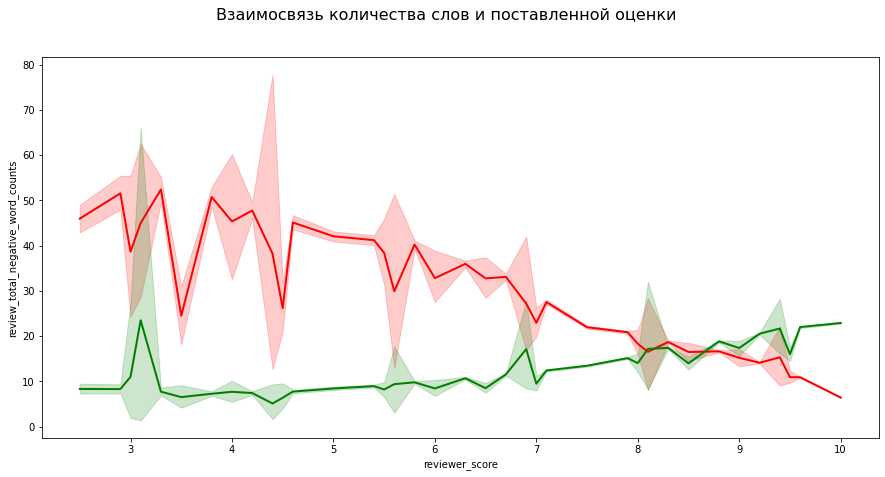

In [209]:
mask = hotels_copy['sample'] == 1
fig6, ax6 = plt.subplots(figsize=(15, 7))
plt.suptitle('Взаимосвязь количества слов и поставленной оценки', size=16)
line_count_neg = sns.lineplot(
    data=hotels_copy[mask],
    x='reviewer_score',
    y='review_total_negative_word_counts',
    color='red', linewidth=2
)
line_count_pos = sns.lineplot(
    data=hotels_copy[mask],
    x='reviewer_score',
    y='review_total_positive_word_counts',
    color='green', linewidth=2
)

главный вывод: признаки кол-ва слов в положит и отриц отзывах взаимодополняющие и т.о. необходимо их скалировать и использовать разницу!!!

In [210]:
hotels_copy['review_total_words'] = hotels_copy['review_total_positive_word_counts'] + hotels_copy['review_total_negative_word_counts']
hotels_copy.shape[0]

515738

In [211]:
mask = hotels_copy['review_total_words'] != 0
hotels_copy['review_positive_word_proportion'] = hotels_copy[mask]['review_total_positive_word_counts']/hotels_copy[mask]['review_total_words']
hotels_copy['review_positive_word_proportion'].fillna(0, inplace=True)
hotels_copy['review_positive_word_proportion'].isnull().mean()
hotels_copy.shape[0]

515738

Удалим ненужные столбцы

In [219]:
hotels_copy.drop(['days_since_review','review_total_positive_word_counts', 'review_total_negative_word_counts', 'review_total_words'], axis=1, inplace=True)

KeyError: "['review_total_positive_word_counts', 'review_total_negative_word_counts', 'review_total_words'] not found in axis"

In [220]:
hotels_copy.drop(['review_date','days_since_review','total_number_of_reviews_reviewer_has_given'], axis=1, inplace=True)

In [223]:
hotels_copy.drop(['negative_clean','positive_clean','negative_nltk','positive_nltk'], axis=1, inplace=True)

In [225]:
hotels_copy.info()
columns = hotels_copy.columns.tolist()
print(columns[:10])
print(columns[10:20])
print(columns[20:])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 30 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   additional_number_of_scoring      515738 non-null  int64  
 1   average_score                     515738 non-null  float64
 2   total_number_of_reviews           515738 non-null  int64  
 3   lat                               512470 non-null  float64
 4   lng                               512470 non-null  float64
 5   sample                            515738 non-null  int64  
 6   reviewer_score                    515738 non-null  float64
 7   hotel_country_code                515738 non-null  int8   
 8   western_nation                    515738 non-null  int64  
 9   islamic_nation                    515738 non-null  int64  
 10  eastern_nation                    515738 non-null  int64  
 11  israel_nation                     515738 non-null  i

##  Оценка мультиколлинеарности среди признаков

Создаем списки непрерывных числовых и категориальных признаков 

In [227]:
num_cols = ['total_number_of_reviews','tag_count','n_review_neg',
            'n_review_neu', 'n_review_pos', 'n_review_compound',
            'p_review_neg', 'p_review_neu', 'p_review_pos',
            'p_review_compound', 'review_clean_positive_proportion', 
            'review_positive_word_proportion']
cat_cols = ['additional_number_of_scoring', 'average_score', 
            'lat', 'lng', 'sample', 'reviewer_score', 
            'hotel_country_code', 'western_nation', 'islamic_nation',
            'eastern_nation', 'israel_nation', 'asian_nation', 
            'english_speaking', 'other_nation', 
            'length_of_stay', 'type_of_travel', 'travelers_number', 
            'pet']

<AxesSubplot:>

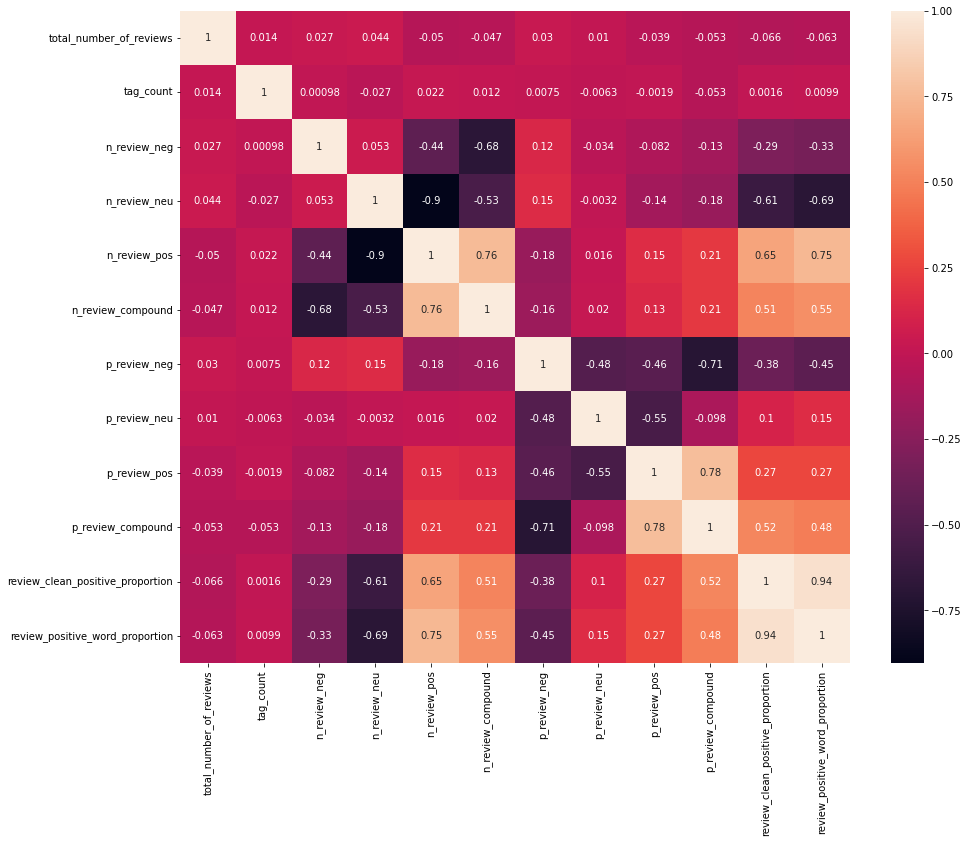

In [231]:
corr = hotels_copy[num_cols].corr()
fig_, ax_ = plt.subplots(figsize=(15, 12))
sns.heatmap(corr, annot=True)

In [243]:
# удалим признаки 'n_review_neu', 'review_positive_word_proportion'
drop_list = ['n_review_neu','review_positive_word_proportion']

проверим категориальные признаки

<AxesSubplot:>

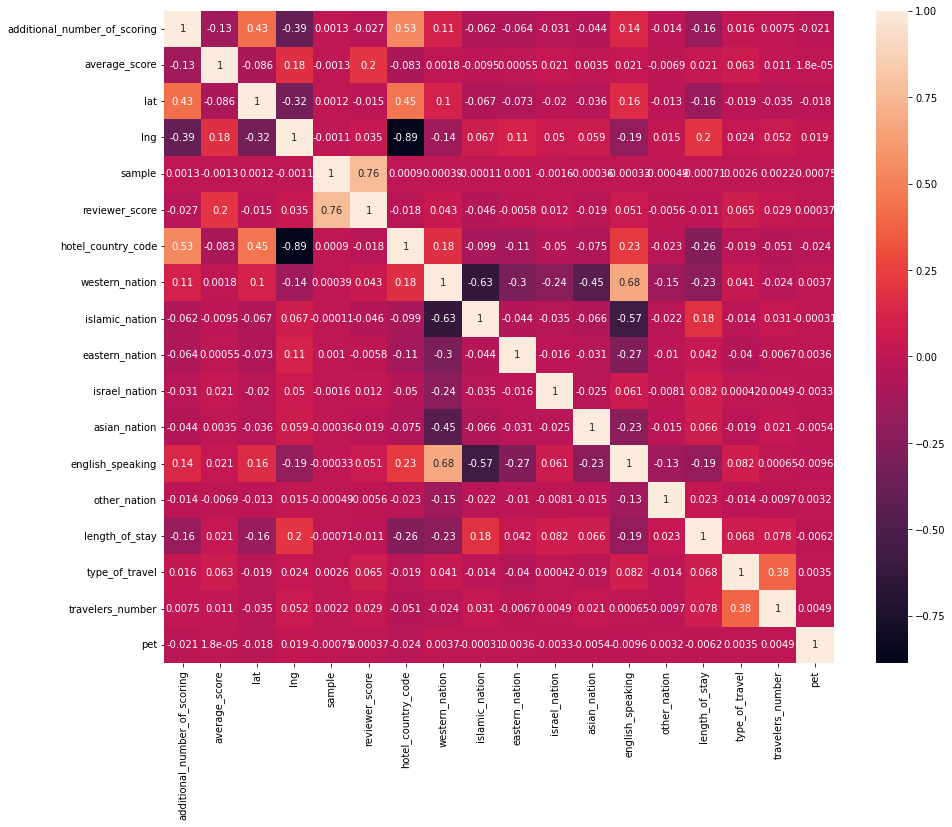

In [232]:
corr = hotels_copy[cat_cols].corr(method='spearman')
fig_, ax_ = plt.subplots(figsize=(15, 12))
sns.heatmap(corr, annot=True)

In [244]:
# удалим lat lng
drop_list.append('lat')
drop_list.append('lng')
drop_list

['n_review_neu', 'review_positive_word_proportion', 'lat', 'lng']

In [246]:
hotels_copy.drop('review_positive_word_proportion', axis=1, inplace=True)

## Оценка значимости признаков

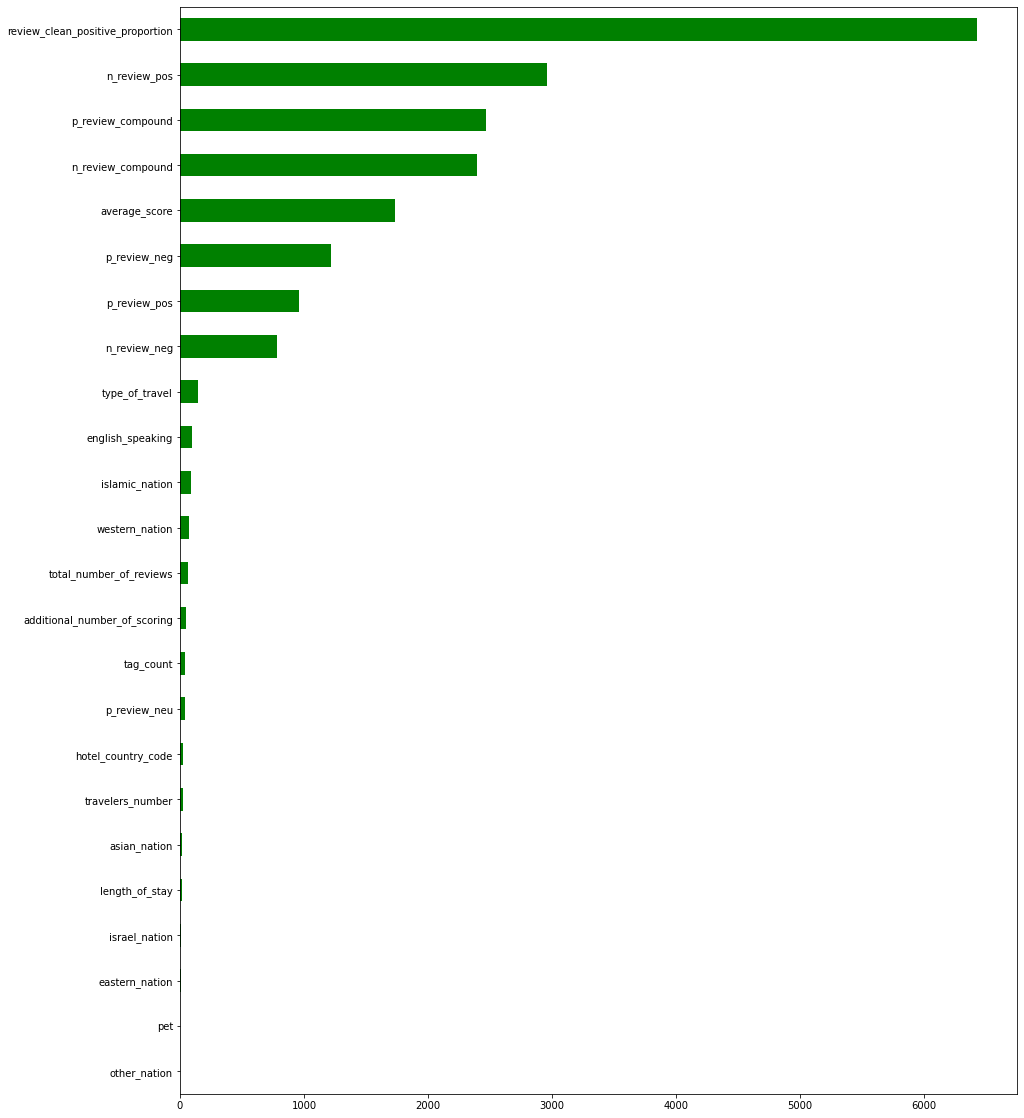

In [247]:
y = hotels_copy.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
X = hotels_copy.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

# визуализируем результат анализа значимости:
imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh', color='green');

In [248]:
drop_list2 = ['total_number_of_reviews', 'additional_number_of_scoring', 
              'tag_count', 'p_review_neu', 'hotel_country_code',
              'travelers_number', 'asian_nation','length_of_stay','israel_nation',
              'eastern_nation','pet','other_nation']

In [249]:
hotels_copy.drop(drop_list2, axis=1, inplace=True)

In [250]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels_copy.drop(['reviewer_score'], axis = 1)  
y = hotels_copy['reviewer_score'] 

In [251]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [252]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [253]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [254]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.09394198758362207


Небольшой бонус:


In [ ]:
# # убираем признаки которые еще не успели обработать, 
# # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
# object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
# hotels.drop(object_columns, axis = 1, inplace=True)

# # заполняем пропуски самым простым способом
# hotels = hotels.fillna(0)

: 